In [1]:
#Imports

from import_images import getImages
from import_model import get_cellpose_model
from make_predictions import makePredictions
import numpy as np

import torch

from cellpose import resnet_torch
from cellpose import transforms
from cellpose import utils
import cv2

import time

from unet_architecture import UNet
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision
import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

c:\Users\rz200\AppData\Local\anaconda3\envs\cellprob\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
images_directory = "C:\\Users\\rz200\\Documents\\development\\distillCellSegTrack\\pipeline\\uploads\\"
#images_directory = "/Users/rehanzuberi/Documents/Development/distillCellSegTrack/pipeline/uploads"
file_names, images = getImages(images_directory)
images_torch = torch.from_numpy(np.array(images))

directory = "C:\\Users\\rz200\\Documents\\development\\distillCellSegTrack\\datasets\\Fluo-C2DL-Huh7\\01\\models\\CP_20230601_101328"
#directory = "/Users/rehanzuberi/Documents/Development/distillCellSegTrack/datasets/Fluo-C2DL-Huh7/01/models/CP_20230601_101328"
cpnet = resnet_torch.CPnet(nbase=[2,32,64,128,256],nout=3,sz=3)
cpnet.load_model(directory)

def get_pre_activations(image,cpnet):
    rescale = cpnet.diam_mean/cpnet.diam_labels
    shape1, shape2 = image.shape[0], image.shape[1]

    x = transforms.resize_image(image, rsz=rescale,no_channels=True)
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=0)
    x = np.concatenate((x, x), axis=0)
    x = torch.from_numpy(x)
    x = x.unsqueeze(0)

    downsample = cpnet.downsample(x)
    downsample_return = downsample[1].squeeze(0)
    downsample_return = downsample_return.cpu().detach().numpy().tolist()

    for (k, image) in enumerate(downsample_return):
        downsample_return[k] = cv2.resize(np.array(image), dsize=(512, 512), interpolation=cv2.INTER_NEAREST)
    downsample_return = np.array(downsample_return)
    downsample_return = torch.from_numpy(downsample_return)


    style = cpnet.make_style(downsample[-1])
    upsample = cpnet.upsample(style, downsample, cpnet.mkldnn)

    output = cpnet.output(upsample)
    output = output.squeeze(0)
    output = output[2]
    
    print(output.shape)
    output = output.cpu().detach().numpy().tolist()
    output = cv2.resize(np.array(output), dsize=(1024, 1024), interpolation=cv2.INTER_NEAREST)
    output = np.array(output)
    #output = torch.from_numpy(output)

    upsample = upsample.squeeze(0)
    upsample = upsample.cpu().detach().numpy().tolist()
    for (k, image) in enumerate(upsample):
        upsample[k] = cv2.resize(np.array(image), dsize=(1024, 1024), interpolation=cv2.INTER_NEAREST)
    upsample = np.array(upsample)
    #upsample = torch.from_numpy(upsample)

    return downsample_return, upsample, output

In [3]:
cp_downsamples = []
cp_upsamples = []
cp_outputs = []
for image in images:
    downsample, upsample, output = get_pre_activations(image,cpnet)
    cp_downsamples.append(downsample)
    cp_upsamples.append(upsample)
    cp_outputs.append(output)

torch.Size([536, 536])
torch.Size([536, 536])
torch.Size([536, 536])
torch.Size([536, 536])
torch.Size([536, 536])
torch.Size([536, 536])
torch.Size([536, 536])
torch.Size([536, 536])
torch.Size([536, 536])
torch.Size([536, 536])
torch.Size([536, 536])


In [6]:
unet = UNet(encChannels=(1,32,64,128,256),decChannels=(256,128,64,32),nbClasses=1)
unet = unet.to('cuda:0')

#get an example torch array
x = images_torch[0]
x = x.unsqueeze(0)
x = x.unsqueeze(0)
x = x.to('cuda:0')
y_16, y_32, pred = unet(x)

In [45]:
print(cp_outputs[2].shape)

(1024, 1024)


In [9]:
class ImageDataset(Dataset):
    def __init__(self, image, upsample, cellprob):
        self.image = image
        self.upsample = upsample
        self.cellprob = cellprob

    def __len__(self):
        return len(self.image)

    def __getitem__(self, idx):
        img = self.image[idx]
        upsample = self.upsample[idx]
        cellprob = self.cellprob[idx]
        return img, upsample, cellprob

In [10]:
def get_crops(image,size):
    assert image.shape[0]%size == 0
    assert image.shape[0] == image.shape[1]
    crops = []
    for i in range(0,image.shape[0],size):
        for j in range(0,image.shape[1],size):
            crops.append(image[i:i+size,j:j+size])
    return crops

def reconstruct_image(crops, size):
    assert len(crops) > 0

    image_size = 1024
    size = 256
    image = np.zeros((image_size, image_size), dtype=np.uint8)

    crop_idx = 0
    for i in range(0, image_size, size):
        for j in range(0, image_size, size):
            image[i:i+size, j:j+size] = crops[crop_idx]
            crop_idx += 1

    return image


In [11]:
import torchvision.transforms as T

train_images, test_images, train_upsamples, test_upsamples, train_cellprob, test_cellprob = train_test_split(images_torch, cp_upsamples, cp_outputs, test_size=0.1, random_state=42)

normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
images_normalised = []
for image in train_images:
    min_val = torch.min(image)
    max_val = torch.max(image)
    normalized_image = (image - min_val) / (max_val - min_val)
    images_normalised.append(normalized_image)

images_torch_rotated = []
for image in images_normalised:
    images_torch_rotated.append(image)
    for i in range(3):
        image = torch.rot90(image, 1, [0, 1])
        images_torch_rotated.append(image)
print(1)

images_torch_rotated_flipped = []
for image in images_torch_rotated:
    images_torch_rotated_flipped.append(image)
    images_torch_rotated_flipped.append(torch.flip(image, [1]))
print(2)

cp_upsamples_normalised = []
for upsample in train_upsamples:
    min_val = np.min(upsample)
    max_val = np.max(upsample)
    normalized_upsample = (upsample - min_val) / (max_val - min_val)
    cp_upsamples_normalised.append(normalized_upsample)

cp_upsamples_rotated = []
for upsample in cp_upsamples_normalised:
    cp_upsamples_rotated.append(upsample)
    for i in range(3):
        upsample = np.rot90(upsample, 1, [1, 2])
        cp_upsamples_rotated.append(upsample)
print(5)

cp_upsamples_rotated_flipped = []
for upsample in cp_upsamples_rotated:
    cp_upsamples_rotated_flipped.append(upsample)
    cp_upsamples_rotated_flipped.append(np.flip(upsample, [2]))
print(6)

#cp_outputs_normalised = []
#for output in train_cellprob:
#    min_val = np.min(output)
#    max_val = np.max(output)
#    normalized_output = (output - min_val) / (max_val - min_val)
#    cp_outputs_normalised.append(normalized_output)

cp_outputs_rotated = []
for output in train_cellprob:
    cp_outputs_rotated.append(output)
    for i in range(3):
        output = np.rot90(output, 1, [0, 1])
        cp_outputs_rotated.append(output)
print(7)

cp_outputs_rotated_flipped = []
for output in cp_outputs_rotated:
    cp_outputs_rotated_flipped.append(output)
    cp_outputs_rotated_flipped.append(np.flip(output, [1]))
print(8)

images_cropped = []
for image in images_torch_rotated_flipped:
    crops = get_crops(image,256)
    for crop in crops:
        images_cropped.append(crop)

cp_upsampled_cropped = []
for (i,upsample) in enumerate(cp_upsamples_rotated_flipped):
    crops_per_chan = []
    for chan in upsample:
        crops = get_crops(chan,256)
        crops_per_chan.append(crops)

    for j in range(16):
        crop_channels_of_crop = []
        for k in range(32):
           crop_channels_of_crop.append(crops_per_chan[k][j])
        crop_channels_of_crop = np.array(crop_channels_of_crop)
        crop_channels_of_crop = crop_channels_of_crop.copy()
        crop_channels_of_crop = torch.from_numpy(crop_channels_of_crop)
        cp_upsampled_cropped.append(crop_channels_of_crop)

cp_outputs_cropped = []
for output in cp_outputs_rotated_flipped:
    crops = get_crops(output,256)
    for crop in crops:
        crop = torch.from_numpy(crop.copy())
        cp_outputs_cropped.append(crop)



1
2
5
6
7
8


In [12]:
print(cp_outputs_cropped[0])

tensor([[-8.0611, -8.0611, -7.8617,  ..., -7.8800, -7.8800, -7.9633],
        [-8.0611, -8.0611, -7.8617,  ..., -7.8800, -7.8800, -7.9633],
        [-8.0479, -8.0479, -8.0389,  ..., -8.1498, -8.1498, -8.2365],
        ...,
        [-8.5948, -8.5948, -8.7509,  ..., -0.6048, -0.6048,  1.8554],
        [-8.5948, -8.5948, -8.7509,  ..., -0.6048, -0.6048,  1.8554],
        [-8.4220, -8.4220, -8.7418,  ..., -0.1880, -0.1880,  2.3987]],
       dtype=torch.float64)


In [7]:
cp_outputs_sigmoided = []
for output in cp_outputs_cropped:
    cp_outputs_sigmoided.append(torch.sigmoid(output))

cp_outputs_np = []
for output in cp_outputs_sigmoided:
    cp_outputs_np.append(output.numpy())

#I want to append to each cp_output the 1 - cp_output
cp_outputs_sigmoided_with_invert = []
for output in cp_outputs_sigmoided:
    new_output = []
    new_output.append(output)
    inverted_output = 1 - output
    new_output.append(inverted_output)
    print(output)
    print(1 - output)
    new_output = torch.stack((output, inverted_output),0)
    #new_output = np.array(new_output)
    #new_output = torch.tensor(new_output)
    cp_outputs_sigmoided_with_invert.append(new_output)

tensor([[0.5403, 0.5403, 0.5413,  ..., 0.5412, 0.5412, 0.5408],
        [0.5403, 0.5403, 0.5413,  ..., 0.5412, 0.5412, 0.5408],
        [0.5404, 0.5404, 0.5404,  ..., 0.5399, 0.5399, 0.5394],
        ...,
        [0.5376, 0.5376, 0.5368,  ..., 0.5777, 0.5777, 0.5899],
        [0.5376, 0.5376, 0.5368,  ..., 0.5777, 0.5777, 0.5899],
        [0.5385, 0.5385, 0.5369,  ..., 0.5798, 0.5798, 0.5926]],
       dtype=torch.float64)
tensor([[0.4597, 0.4597, 0.4587,  ..., 0.4588, 0.4588, 0.4592],
        [0.4597, 0.4597, 0.4587,  ..., 0.4588, 0.4588, 0.4592],
        [0.4596, 0.4596, 0.4596,  ..., 0.4601, 0.4601, 0.4606],
        ...,
        [0.4624, 0.4624, 0.4632,  ..., 0.4223, 0.4223, 0.4101],
        [0.4624, 0.4624, 0.4632,  ..., 0.4223, 0.4223, 0.4101],
        [0.4615, 0.4615, 0.4631,  ..., 0.4202, 0.4202, 0.4074]],
       dtype=torch.float64)
tensor([[0.5408, 0.5408, 0.5406,  ..., 0.5411, 0.5411, 0.5407],
        [0.5408, 0.5408, 0.5406,  ..., 0.5411, 0.5411, 0.5407],
        [0.5393, 0.5

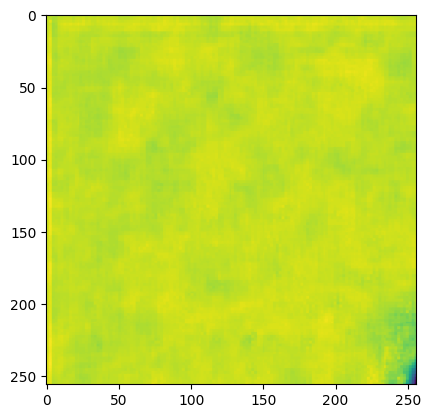

In [8]:
plt.imshow(cp_outputs_sigmoided_with_invert[0][0])
plt.imshow(cp_outputs_sigmoided_with_invert[0][1])


In [13]:
train_dataset = ImageDataset(images_cropped, cp_upsampled_cropped, cp_outputs_cropped)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

test_dataset = ImageDataset(test_images, test_upsamples, test_cellprob)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [14]:
print(torch.unique(cp_outputs_cropped[0]))

tensor([-9.2256, -9.1397, -9.1304,  ...,  1.0896,  1.8554,  2.3987],
       dtype=torch.float64)


In [65]:
def process_y_3_pred(y_3_pred,sigmoid=False):
    y_3_pred_rows = []
    for i in range(0, 16, 4):
        row = []
        for j in range(i, i + 4):
            row.append(y_3_pred[j])
        row = np.concatenate(row, axis=1)
        y_3_pred_rows.append(row)

    y_3_pred = np.concatenate(y_3_pred_rows, axis=0)
    if sigmoid:
        y_3_pred = 1 / (1 + np.exp(-y_3_pred))
    return y_3_pred

In [38]:
from torch.autograd import Variable

class LF_three(torch.nn.Module):
    def __init__(self, alpha, beta, gamma):
        super(LF_three, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma

    def forward(self, y_32_pred, y_32_true, y_3_pred, y_3_true):

        #32-channel loss
        y_32_pred = F.sigmoid(y_32_pred)
        y_32_true = F.sigmoid(y_32_true)
        y_32_loss = F.mse_loss(y_32_pred, y_32_true.float())
        
        #map loss
        #1 bce loss

        desired_min_value = -17.0
        desired_max_value = 33.0

        # Step 1: Calculate the minimum and maximum values in the logits
        min_value = torch.min(y_3_pred)
        max_value = torch.max(y_3_pred)

        # Step 2: Compute the scaling factors
        scaled_logits = (y_3_pred - min_value) / (max_value - min_value)

        # Step 3: Map the scaled logits to the desired range
        scaled_logits = scaled_logits * (desired_max_value - desired_min_value) + desired_min_value


        y_3_bce_loss = F.mse_loss(y_3_pred, y_3_true.float())
        #2 IoU loss
        y_3_pred_sig = torch.sigmoid(y_3_pred)
        y_3_true_sig = torch.sigmoid(y_3_true)
        y_3_pred_bin = torch.where(y_3_pred_sig > 0.5, 1.0, 0.0)
        y_3_true_bin = torch.where(y_3_true_sig > 0.5, 1.0, 0.0)
        #print(torch.unique(y_3_true_bin, return_counts=True))
        y_3_pred_bin = y_3_pred_bin.view(-1)
        y_3_true_bin = y_3_true_bin.view(-1)
        intersection = (y_3_pred_bin * y_3_true_bin).sum()
        total = (y_3_pred_bin + y_3_true_bin).sum()
        union = total - intersection 
        IoU_loss = 1 - (intersection + 1)/(union + 1)

        #print(y_3_bce_loss, IoU_loss)

        return y_32_loss * self.alpha + y_3_bce_loss * self.beta + IoU_loss * self.gamma
    
class FocalLoss(torch.nn.Module) :
    def __init__(self, gamma=0, alpha=None, size_average=True) :
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha, (float, int)) :
            self.alpha = torch.Tensor([alpha, 1 - alpha])
        if isinstance(alpha, list) :
            self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target) :
        if input.dim() > 2 :
            input = input.view(input.size(0), input.size(1), -1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1, 2)  # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1, input.size(2))  # N,H*W,C => N*H*W,C
        target = target[:, 1 :].contiguous()
        target = target.view(-1, 1)
        logpt = F.log_softmax(input, -1)
        logpt = logpt.gather(1, target.to(torch.int64))
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None :
            if self.alpha.type() != input.data.type() :
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0, target.data.view(-1).to(torch.int64))
            logpt = logpt * Variable(at)

        loss = -(1 - pt) ** self.gamma * logpt
        if self.size_average :
            return loss.mean()
        else :
            return loss.sum()
        
def dice_loss(prediction, target) :
    """Calculating the dice loss
    Args:
        prediction = predicted image
        target = Targeted image
    Output:
        dice_loss"""

    smooth = 1.0

    prediction = torch.softmax(prediction, dim=1)[:, 1:].contiguous()
    target = target[:, 1:].contiguous()

    i_flat = prediction.view(-1)
    t_flat = target.view(-1)

    intersection = (i_flat * t_flat).sum()

    return 1 - ((2. * intersection + smooth) / (i_flat.sum() + t_flat.sum() + smooth))

In [79]:
def trainEpoch(unet, train_loader, test_loader, loss_fn, optimiser, scheduler, epoch_num, step, device):
    time_start = time.time()
    
    unet.train()

    train_loss = 0
    for image, upsample, cp_output in train_loader:
        #cast to float32
        image = image.float()
        upsample = upsample.float()
        cp_output = cp_output.float()
        (image, upsample, cp_output) = (image.to(device),upsample.to(device),cp_output.to(device)) # sending the data to the device (cpu or GPU)

        image = image.unsqueeze(1)
        y_16_pred, y_32_pred, y_3_pred = unet(image)
        y_32_pred = y_32_pred.squeeze(1)
        y_3_pred = y_3_pred.squeeze(1)

        #print(y_3_pred.shape)
        
        #pred, predicted_masks, cellprob, cellmask = pred.squeeze(0), predicted_masks.float().squeeze(0), cellprob.squeeze(0), cellmask.squeeze(0)
        
        if step == 1:
            #transform = T.Resize(512)
            #y_32_pred = transform(y_32_pred)
            loss = loss_fn(y_32_pred,  upsample) # calculate the loss of that prediction
            #loss = loss_fn(y_32_pred, upsample, cp_output)
        elif step == 2:
            if 4 == 5:
                kl_loss = torch.nn.KLDivLoss(reduction="mean")
                transform = T.Resize(1024)
                cp_output_t = transform(cp_output)

                y_3_pred = F.sigmoid(y_3_pred)
                #cp_output_t = F.sigmoid(cp_output_t)

                loss = kl_loss(y_3_pred.double().log(), cp_output_t.double().log())
            #transform = T.Resize(512)
            #y_3_pred = transform(y_3_pred)
            #print(y_3_pred.shape, cp_output.shape)
            loss = loss_fn(y_3_pred, cp_output)
            #transform = T.Resize(1024)
            #cp_output_t = transform(cp_output)
            #cp_output_t_bin = torch.where(cp_output_t > 0.5,
                                      #torch.ones_like(cp_output_t),
                                      #torch.zeros_like(cp_output_t))
            #loss = loss_fn(y_3_pred, cp_output_t)
            #transform = T.Resize(512)
            #y_3_pred = transform(y_3_pred)
            #loss = loss_fn(y_3_pred,  cp_output)
        elif step == 3:
            loss = loss_fn(y_32_pred,  upsample, y_3_pred, cp_output) # calculate the loss of that prediction
            

        train_loss += loss
        optimiser.zero_grad() # zero out the accumulated gradients
        loss.backward() # backpropagate the loss
        optimiser.step() # update model parameters
        if scheduler is not None:
            scheduler.step()
    train_loss = train_loss.item()/len(train_loader)

    if 4 == 4:
        if step == 2 or step == 3:
            iou_score = 0
            for image, upsample, cp_output in test_loader:
                image = image.float()
                upsample = upsample.float()
                cp_output = cp_output.float()
                y_16_pred, y_32_pred, y_3_pred = unet(image.to('cuda:0').unsqueeze(1))

                image_crops = get_crops(image.squeeze(),256)
                y_3_pred = []
                for crop in image_crops:
                    crop = crop.unsqueeze(0)
                    crop = crop.unsqueeze(0)
                    y_16_pred, y_32_pred, pred = unet(crop.to('cuda:0'))
                    pred = pred.squeeze()
                    #pred = F.sigmoid(pred)
                    pred = pred.cpu().detach().numpy().tolist()
                    y_3_pred.append(pred)

                #plt.imshow(y_3_pred[3])

                y_3_pred_1 = process_y_3_pred(y_3_pred,sigmoid=True) > 0.5

                cp_output = F.sigmoid(cp_output) > 0.5
                cp_output = cp_output.cpu().detach().numpy()
                cp_output = np.squeeze(cp_output)

                intersection = np.logical_and(cp_output, y_3_pred_1)
                union = np.logical_or(cp_output, y_3_pred_1)
                iou_score += np.sum(intersection) / np.sum(union)

            if 4 == 5:
                for image, upsample, cp_output in test_loader:
                    
                    (image, upsample, cp_output) = (image.to(device),upsample.to(device),cp_output.to(device))

                    image = image.unsqueeze(1)

                    image_crops = get_crops(image.squeeze(),256)
                    y_3_pred = []
                    for crop in image_crops:
                        crop = crop.unsqueeze(0)
                        crop = crop.unsqueeze(0)
                        y_16_pred, y_32_pred, pred = unet(crop)
                        pred = pred.squeeze()
                        pred = F.softmax(pred)
                        pred = pred.cpu().detach().numpy().tolist()
                        y_3_pred.append(pred)

                    y_3_pred_first_channel = []
                    y_3_pred_second_channel = []
                    for crop in y_3_pred:
                        y_3_pred_first_channel.append(crop[0])
                        y_3_pred_second_channel.append(crop[1])

                    y_3_pred_1 = process_y_3_pred(y_3_pred_first_channel)
                    y_3_pred_2 = process_y_3_pred(y_3_pred_second_channel)
                    #y_3_pred = reconstruct_image(y_3_pred,256)

                    #y_16_pred, y_32_pred, y_3_pred = unet(image)
                    
                    #y_32_pred = y_32_pred.squeeze(1)
                    #y_3_pred = y_3_pred.squeeze(1)
                    
                    y_3_pred_1 = 1/(1+np.exp(-y_3_pred_1))
                    y_3_pred_1 = np.array(y_3_pred_1)
                    y_3_pred_1 = np.squeeze(y_3_pred_1)
                    y_3_pred_1 = y_3_pred_1 > 0.5
                    y_3_pred_1 = y_3_pred_1.astype(int)

                    y_3_pred_2 = 1/(1+np.exp(-y_3_pred_2))
                    y_3_pred_2 = np.array(y_3_pred_2)
                    y_3_pred_2 = np.squeeze(y_3_pred_2)
                    y_3_pred_2 = y_3_pred_2 > 0.5
                    y_3_pred_2 = y_3_pred_2.astype(int)

                    #transform = T.Resize(1024)
                    #cp_output = transform(cp_output)

                    cp_output = cp_output.cpu().detach().numpy()
                    cp_output = np.squeeze(cp_output)

                    cp_output_1 = cp_output[0]
                    cp_output_1 = cp_output_1 > 0.5
                    cp_output_1 = cp_output_1.astype(int)

                    cp_output_2 = cp_output[1]
                    cp_output_2 = cp_output_2 > 0.5
                    cp_output_2 = cp_output_2.astype(int)

                    
                    if epoch_num % 20 == 0:
                        print(np.unique(y_3_pred,return_counts=True), np.unique(cp_output))
                        plt.subplot(1,2,1)
                        plt.imshow(y_3_pred_1)
                        plt.subplot(1,2,2)
                        plt.imshow(cp_output)
                        plt.show()
                    
                    break


            iou_score = iou_score/len(test_loader)

    if epoch_num is None:
        print('Training loss: ', train_loss, 'Time: ', time.time()-time_start)
    else:
        if step == 1:
            print('Epoch ', epoch_num, 'Training loss: ', train_loss, 'Time: ', time.time()-time_start)
        elif step == 2:
            print('Epoch ', epoch_num, 'Training loss: ', train_loss, 'IoU score: ', iou_score, 'Time: ', time.time()-time_start)
        elif step == 3:
            print('Epoch ', epoch_num, 'Training loss: ', train_loss, 'IoU score: ', iou_score, 'Time: ', time.time()-time_start)

    return unet

In [30]:
unet = UNet(encChannels=(1,32,64,128,256),decChannels=(256,128,64,32),nbClasses=1)
unet = unet.to('cuda:0')

In [33]:
#TODO: add test loss here
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
third_loss_fn = LF_three(alpha=1.0, beta=0.0, gamma=0.0)
#loss_fn = reg_con()
optimiser = torch.optim.SGD(unet.parameters(), lr=1, momentum=0.1)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimiser, base_lr=0.0000001, max_lr=1)

for epoch in range(5):
    unet = trainEpoch(unet, train_loader, test_loader, third_loss_fn, optimiser, scheduler=scheduler, epoch_num=epoch,device='cuda:0',step=3)

C:\Users\rz200\AppData\Local\Temp\ipykernel_21896\1639306057.py:81: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(pred)


Epoch  0 Training loss:  5.868658061242766e-05 IoU score:  1.0 Time:  16.725416660308838
Epoch  1 Training loss:  3.6019848064622944e-05 IoU score:  1.0 Time:  16.61235737800598
Epoch  2 Training loss:  2.005871566426423e-05 IoU score:  1.0 Time:  16.360023260116577
Epoch  3 Training loss:  1.6224788851104677e-05 IoU score:  1.0 Time:  16.586122035980225
Epoch  4 Training loss:  1.4704010229454272e-05 IoU score:  1.0 Time:  16.988048791885376


In [81]:
third_loss_fn = LF_three(alpha=0.0, beta=1.0, gamma=0.0)
#loss_fn = reg_con()
optimiser = torch.optim.SGD(unet.parameters(), lr=0.001, momentum=0.1)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimiser, base_lr=0.0000001, max_lr=0.001)
#sanity ceck to make sure we're doing rihg tbefore the simoid, on the ligits so not the probabilitieis
for epoch in range(400):
    unet = trainEpoch(unet, train_loader, test_loader, third_loss_fn, optimiser, scheduler=scheduler, epoch_num=epoch,device='cuda:0',step=3)

In [ ]:
#TODO: add test loss here
third_loss_fn = LF_three(alpha=0.0, beta=0.0, gamma=1.0)
#loss_fn = reg_con()
optimiser = torch.optim.SGD(unet.parameters(), lr=0.1, momentum=0.1)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimiser, base_lr=0.0001, max_lr=0.01)

for epoch in range(200):
    unet = trainEpoch(unet, train_loader, test_loader, third_loss_fn, optimiser, scheduler=scheduler, epoch_num=epoch,device='cuda:0',step=3)

Epoch  0 Training loss:  0.25330861409505206 IoU score:  0 Time:  15.83679723739624
Epoch  1 Training loss:  0.25330861409505206 IoU score:  0 Time:  16.223405361175537
Epoch  2 Training loss:  0.25330861409505206 IoU score:  0 Time:  15.820126295089722


KeyboardInterrupt: 

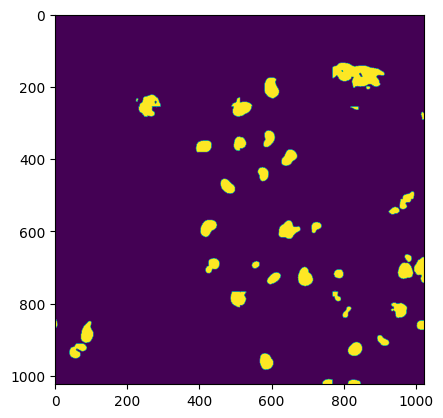

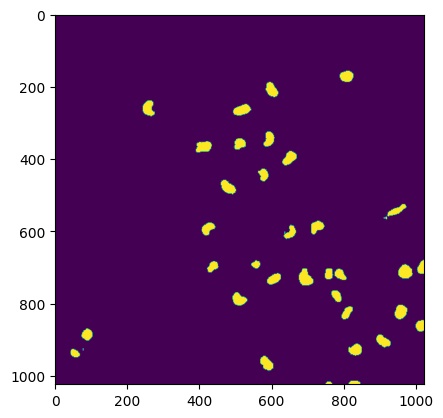

0.5285317236287836


In [78]:
for image, upsample, cp_output in test_loader:
    #cp_output = F.sigmoid(cp_output)

    #print(cp_output)
    y_16_pred, y_32_pred, y_3_pred = unet(image.to('cuda:0').unsqueeze(1))

    image_crops = get_crops(image.squeeze(),256)
    y_3_pred = []
    for crop in image_crops:
        crop = crop.unsqueeze(0)
        crop = crop.unsqueeze(0)
        y_16_pred, y_32_pred, pred = unet(crop.to('cuda:0'))
        pred = pred.squeeze()
        #pred = F.sigmoid(pred)
        pred = pred.cpu().detach().numpy().tolist()
        y_3_pred.append(pred)

    #plt.imshow(y_3_pred[3])

    y_3_pred_1 = process_y_3_pred(y_3_pred,sigmoid=True) > 0.5
    plt.imshow(y_3_pred_1); plt.show()

    cp_output = F.sigmoid(cp_output) > 0.5
    cp_output = cp_output.cpu().detach().numpy()
    cp_output = np.squeeze(cp_output)

    plt.imshow(cp_output); plt.show()


    intersection = np.logical_and(cp_output, y_3_pred_1)
    union = np.logical_or(cp_output, y_3_pred_1)
    iou_score = np.sum(intersection) / np.sum(union)

    print(iou_score)

    #plt.imshow(cp_output[0])
    break

In [21]:
test_image = test_images[0]
test_image = test_image.to('cuda:0')
test_image = test_image.unsqueeze(1)

image_crops = get_crops(test_image.squeeze(),256)
y_3_pred = []
for crop in image_crops:
    crop = crop.unsqueeze(0)
    crop = crop.unsqueeze(0)
    y_16_pred, y_32_pred, pred = unet(crop)
    pred = pred.squeeze()
    pred = F.sigmoid(pred)
    pred = pred.cpu().detach().numpy().tolist()
    y_3_pred.append(pred)

y_3_pred_first_channel = []
y_3_pred_second_channel = []
for crop in y_3_pred:
    y_3_pred_first_channel.append(crop[0])
    y_3_pred_second_channel.append(crop[1])

y_3_pred_1 = process_y_3_pred(y_3_pred_first_channel)
y_3_pred_2 = process_y_3_pred(y_3_pred_second_channel)

#y_3_pred_first_channel = np.array(y_3_pred_first_channel)
#y_3_pred_second_channel = np.array(y_3_pred_second_channel)
#y_3_pred_first_channel = torch.tensor(y_3_pred_first_channel)
#y_3_pred_second_channel = torch.tensor(y_3_pred_second_channel)
#new_output = torch.stack((y_3_pred_first_channel, y_3_pred_second_channel),0)

c:\Users\rz200\AppData\Local\anaconda3\envs\cellprob\lib\site-packages\torch\nn\functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[[0.64778135 0.65536001 0.6586593  ... 0.66321897 0.66863132 0.65714851]
 [0.65650525 0.66703513 0.67118882 ... 0.67978565 0.68109033 0.66488015]
 [0.66141854 0.67702599 0.67836741 ... 0.68671465 0.68457122 0.66686705]
 ...
 [0.65493674 0.66212884 0.66452043 ... 0.66653283 0.66416829 0.65474244]
 [0.65348191 0.65823719 0.6616053  ... 0.66318472 0.6618592  0.65258616]
 [0.65122901 0.65504515 0.65683084 ... 0.65676076 0.6552668  0.64885811]]


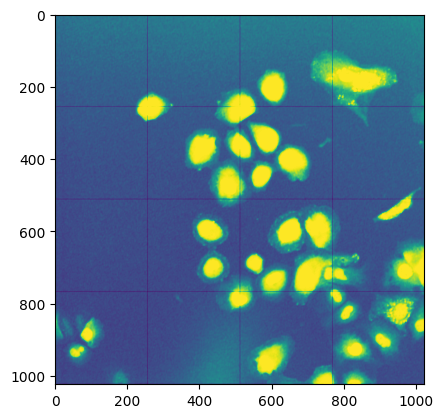

In [22]:
y_3_pred_1 = process_y_3_pred(y_3_pred_first_channel)
y_3_pred_2 = process_y_3_pred(y_3_pred_second_channel)
print(y_3_pred_1)
plt.imshow(y_3_pred_1)

C:\Users\rz200\AppData\Local\Temp\ipykernel_23248\1316640042.py:11: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  y_3_pred_1 = F.log_softmax(y_3_pred_1)


[-6.9674711  -6.96736002 -6.96712353 ... -6.8575739  -6.85748833
 -6.85740818]
(array([0.]), array([1048576], dtype=int64))


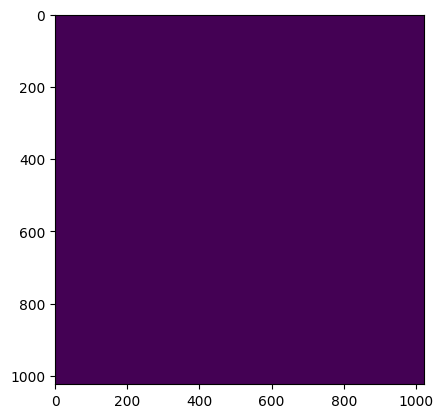

In [23]:
#separate the crops by their channels

y_3_pred_first_channel = []
y_3_pred_second_channel = []
for crop in y_3_pred:
    y_3_pred_first_channel.append(crop[0])
    y_3_pred_second_channel.append(crop[1])

y_3_pred_1 = process_y_3_pred(y_3_pred_first_channel)
y_3_pred_1 = torch.from_numpy(y_3_pred_1)
y_3_pred_1 = F.log_softmax(y_3_pred_1)
print(np.unique(y_3_pred_1))
y_3_pred_1 = y_3_pred_1.cpu().detach().numpy()
y_3_pred_1 = np.where(y_3_pred_1 > 0.5, 1.0, 0.0)
print(np.unique(y_3_pred_1, return_counts=True))
plt.imshow(y_3_pred_1)

y_3_pred_2 = process_y_3_pred(y_3_pred_second_channel)
#plt.imshow(y_3_pred_2)

TypeError: Invalid shape (8, 1024, 256) for image data

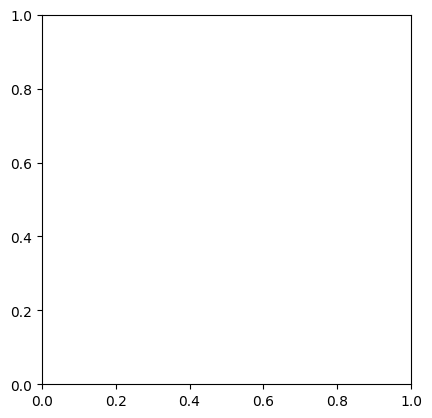

In [ ]:
test_image = test_images[0]
test_image = test_image.to('cuda:0')
test_image = test_image.unsqueeze(1)

image_crops = get_crops(test_image.squeeze(),256)
y_3_pred = []
for crop in image_crops:
    crop = crop.unsqueeze(0)
    crop = crop.unsqueeze(0)
    y_16_pred, y_32_pred, pred = unet(crop)
    pred = pred.squeeze()
    y_3_pred.append(pred.cpu().detach().numpy().tolist())

def process_y_3_pred(y_3_pred):
    y_3_pred_rows = []
    for i in range(0, 16, 4):
        row = []
        for j in range(i, i + 4):
            row.append(y_3_pred[j])
        row = np.concatenate(row, axis=1)
        y_3_pred_rows.append(row)

    y_3_pred = np.concatenate(y_3_pred_rows, axis=0)
    y_3_pred = 1 / (1 + np.exp(-y_3_pred))
    return y_3_pred

y_3_pred = process_y_3_pred(y_3_pred)

#replace values in y_3_pred with 0 or 1 if they are above or below 0.5
y_3_pred = np.where(y_3_pred > 0.5, 1, 0)

plt.imshow(y_3_pred)
plt.show()